Original code by Dede et al. (https://figshare.com/articles/software/enCas12a_screen_analysis_pipeline/12275642), licensed under CC BY 4.0
https://creativecommons.org/licenses/by/4.0/
Modified by Hamda Ajmal, March 2025
Changes: Extracted relevant portions of the code and applied them to different datasets.

In [ ]:
%matplotlib inline
%pylab inline

In [2]:
import pandas as pd
import scipy.stats as stats
import scipy.cluster.hierarchy as clust
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Hamda\anaconda3New\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
reads = pd.read_csv('../InputData/Parrish/GSE178179_pgPEN_counts_PC9.txt', index_col=0, sep='\t')
reads.columns

In [ ]:
reads.drop(['HeLa_plasmid', 'HeLa_ETP', 'HeLa_LTP_RepA', 'HeLa_LTP_RepB', 'HeLa_LTP_RepC'  ], axis=1, inplace=True)

# Correction: WE neet ETPS not plasmids
#reads.drop(['PC9_ETP_RepA', 'PC9_ETP_RepB','PC9_ETP_RepC' ], axis=1, inplace=True) # remove early time points too as we dont need them
reads.drop(['PC9_plasmid' ], axis=1, inplace=True) 
reads['ETP_PC9'] = reads[['PC9_ETP_RepA', 'PC9_ETP_RepB', 'PC9_ETP_RepC']].mean(axis=1)

## drop other columns too, dont need them
reads.drop(['gRNA1_seq', 'gRNA2_seq','PC9_ETP_RepA', 'PC9_ETP_RepB', 'PC9_ETP_RepC'], inplace = True, axis = 1)
reads = reads[['paralog_pair', 'ETP_PC9', 'PC9_LTP_RepA', 'PC9_LTP_RepB', 'PC9_LTP_RepC']]



In [6]:
# Removed Hela before this
numGuides, numSamples = reads.shape

numGuides, numSamples
sample_sum = reads.iloc[:,range(1,numSamples)].sum(0)


,paralog_pair,ETP_PC9,PC9_LTP_RepA,PC9_LTP_RepB,PC9_LTP_RepC
pgRNA_id,,,,,
AADAC_AADACL2_pg1,AADAC|AADACL2,928.666667,1327,821,964
AADAC_AADACL2_pg10,AADAC|AADACL2,887.000000,1030,1174,694
AADAC_AADACL2_pg11,AADAC|AADACL2,76.333333,175,24,93
AADAC_AADACL2_pg12,AADAC|AADACL2,528.333333,660,713,367
AADAC_AADACL2_pg13,AADAC|AADACL2,226.000000,380,157,520
AADAC_AADACL2_pg14,AADAC|AADACL2,522.000000,374,600,425
AADAC_AADACL2_pg15,AADAC|AADACL2,176.666667,169,258,84
AADAC_AADACL2_pg16,AADAC|AADACL2,314.666667,342,229,184
AADAC_AADACL2_pg2,AADAC|AADACL2,1175.000000,1356,803,1152


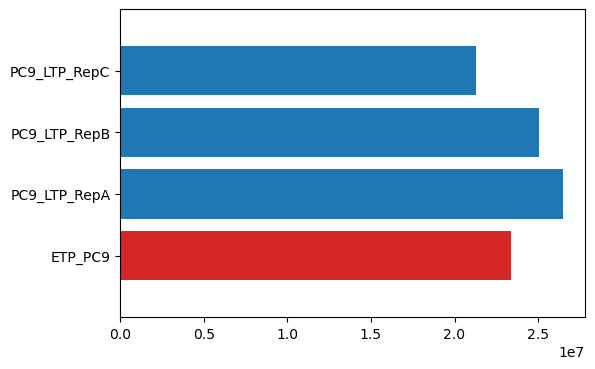

In [7]:
sample_sum = reads.iloc[:,range(1,numSamples)].sum(0)
#
highlight_index = 0
colors = ['tab:blue'] * len(sample_sum)
colors[highlight_index] = 'tab:red'

figure( figsize(6,4))
barh( arange(len(sample_sum)), sample_sum, align='center', color = colors)

ylim(-1, len(sample_sum)) # len(sample_sum) = 10
yticks(arange(len(sample_sum)), reads.columns.values[1:], rotation=0)

show()


In [8]:
pseudo=5

reads[ reads.columns[1:]] = reads[ reads.columns[1:]] + pseudo
reads.head()

,paralog_pair,ETP_PC9,PC9_LTP_RepA,PC9_LTP_RepB,PC9_LTP_RepC
pgRNA_id,,,,,
AADAC_AADACL2_pg1,AADAC|AADACL2,933.666667,1332,826,969
AADAC_AADACL2_pg10,AADAC|AADACL2,892.000000,1035,1179,699
AADAC_AADACL2_pg11,AADAC|AADACL2,81.333333,180,29,98
AADAC_AADACL2_pg12,AADAC|AADACL2,533.333333,665,718,372
AADAC_AADACL2_pg13,AADAC|AADACL2,231.000000,385,162,525


In [9]:
meanReads = reads.iloc[:,range(1,numSamples)].mean(0) # colmean
meanReads

ETP_PC9         710.287388
PC9_LTP_RepA    803.368043
PC9_LTP_RepB    759.624329
PC9_LTP_RepC    647.067742
dtype: float64

In [10]:
# also remove double control "pgRNAs. Five hundred double non-targeting pgRNAs were included as a control"
filtered_reads = reads[reads['paralog_pair'].str.contains('^NTpg.*\|NA$')].index
filtered_reads.shape


(500,)

In [11]:
#reads['paralog_pair'].str.contains('^NTpg.*\|NA$')
reads.drop(filtered_reads, axis = 0, inplace = True)
reads

,paralog_pair,ETP_PC9,PC9_LTP_RepA,PC9_LTP_RepB,PC9_LTP_RepC
pgRNA_id,,,,,
AADAC_AADACL2_pg1,AADAC|AADACL2,933.666667,1332,826,969
AADAC_AADACL2_pg10,AADAC|AADACL2,892.000000,1035,1179,699
AADAC_AADACL2_pg11,AADAC|AADACL2,81.333333,180,29,98
AADAC_AADACL2_pg12,AADAC|AADACL2,533.333333,665,718,372
AADAC_AADACL2_pg13,AADAC|AADACL2,231.000000,385,162,525
...,...,...,...,...,...
nt4_ZYG11A,nt4|ZYG11A,350.000000,176,453,392
nt5_ZYG11A,nt5|ZYG11A,1854.000000,2232,2127,1770
nt6_ZYG11A,nt6|ZYG11A,400.666667,347,489,423


In [12]:
33170 - 500
numGuides, numSamples = reads.shape

numGuides, numSamples 

(32670, 5)

In [13]:
normed = pd.DataFrame(index=reads.index, columns=reads.columns) # empty data frame
normed['paralog_pair'] = reads.iloc[:, 0]
normed.rename(columns={"paralog_pair": "GENE"}, inplace = True)
normed
#pseudo has already been added to reads
#The numpy.tile() function constructs a new array by repeating array – ‘arr’, 
#the number of times we want to repeat as per repetitions. 
#The resulted array will have dimensions max(arr.ndim, repetitions) where, 
#repetitions is the length of repetitions. If arr.ndim > repetitions,
#reps is promoted to arr.ndim by pre-pending 1’s to it.
#If arr.ndim < repetitions, reps is promoted to arr.ndim by pre-pending new axis. Syntax : 
normed[ normed.columns[1:] ] =   (reads.iloc[:, range(1, numSamples)] ) / np.tile(meanReads.values, [numGuides, 1]) * 500  # normalize to mean 500 read
normed.head()


,GENE,ETP_PC9,PC9_LTP_RepA,PC9_LTP_RepB,PC9_LTP_RepC
pgRNA_id,,,,,
AADAC_AADACL2_pg1,AADAC|AADACL2,657.245702,829.009824,543.689800,748.762407
AADAC_AADACL2_pg10,AADAC|AADACL2,627.914852,644.163039,776.041495,540.128919
AADAC_AADACL2_pg11,AADAC|AADACL2,57.253821,112.028355,19.088383,75.726229
AADAC_AADACL2_pg12,AADAC|AADACL2,375.434889,413.882532,472.602030,287.450584
AADAC_AADACL2_pg13,AADAC|AADACL2,162.610236,239.616203,106.631656,405.676227


In [14]:
fc = pd.DataFrame(index=reads.index, columns=reads.columns[[2,3,4]]) # non-normalised
fc['GENE'] = reads['paralog_pair'] 
fc
numFCsamples = fc.shape[1]-1   # number of columns for which to calculate FC
numFCsamples
#fc.head()
pseudo = 0 # remmeber pseudocount is already in the data 
fc.head()
## rearrane here 
cols = ['GENE' ,'PC9_LTP_RepA' ,'PC9_LTP_RepB' ,'PC9_LTP_RepC']
fc = fc[cols]
fc

## VERY IMPORTANT TO REARRANGE NORMED HERE
cols = ['GENE', 'PC9_LTP_RepA', 'PC9_LTP_RepB', 'PC9_LTP_RepC', 'ETP_PC9']
normed = normed[cols]

fc[ fc.columns[1:] ] = log2( (normed[ normed.columns[1:-1]] + pseudo) / np.tile( normed[ normed.columns[-1]] + pseudo , [numFCsamples, 1]).T )
fc

,GENE,PC9_LTP_RepA,PC9_LTP_RepB,PC9_LTP_RepC
pgRNA_id,,,,
AADAC_AADACL2_pg1,AADAC|AADACL2,0.334956,-0.273649,0.188075
AADAC_AADACL2_pg10,AADAC|AADACL2,0.036857,0.305565,-0.217265
AADAC_AADACL2_pg11,AADAC|AADACL2,0.968420,-1.584677,0.403421
AADAC_AADACL2_pg12,AADAC|AADACL2,0.140659,0.332063,-0.385249
AADAC_AADACL2_pg13,AADAC|AADACL2,0.559307,-0.608782,1.318911
...,...,...,...,...
nt4_ZYG11A,nt4|ZYG11A,-1.169438,0.275273,0.297985
nt5_ZYG11A,nt5|ZYG11A,0.090038,0.101296,0.067594
nt6_ZYG11A,nt6|ZYG11A,-0.385125,0.190549,0.212741


In [15]:
## Anything with nt  is control in this study
fc_base = pd.DataFrame(index=fc.index, columns=fc.columns) # non-normalised
fc_base.iloc[:] = fc.iloc[:]
fc_base
fc_base[['GENE1', 'GENE2']] = fc_base.GENE.str.split("|", expand = True)
fc_base.drop(['GENE'], inplace = True,axis=1)
fc_base
fc_base.loc[fc_base['GENE1'].str.contains('^nt[0-8]{1}'),'GENE1'] = 'control'
fc_base.loc[fc_base['GENE2'].str.contains('^nt[0-8]{1}'),'GENE2'] = 'control'

fc_base

,PC9_LTP_RepA,PC9_LTP_RepB,PC9_LTP_RepC,GENE1,GENE2
pgRNA_id,,,,,
AADAC_AADACL2_pg1,0.334956,-0.273649,0.188075,AADAC,AADACL2
AADAC_AADACL2_pg10,0.036857,0.305565,-0.217265,AADAC,AADACL2
AADAC_AADACL2_pg11,0.96842,-1.584677,0.403421,AADAC,AADACL2
AADAC_AADACL2_pg12,0.140659,0.332063,-0.385249,AADAC,AADACL2
AADAC_AADACL2_pg13,0.559307,-0.608782,1.318911,AADAC,AADACL2
...,...,...,...,...,...
nt4_ZYG11A,-1.169438,0.275273,0.297985,control,ZYG11A
nt5_ZYG11A,0.090038,0.101296,0.067594,control,ZYG11A
nt6_ZYG11A,-0.385125,0.190549,0.212741,control,ZYG11A


In [16]:
cells = list([ 'PC9'])
cols = list(['GENE1']) + list( ['GENE2']) + cells
cols
fc_merge = pd.DataFrame( columns=cols, index=fc_base.index, dtype=float)
fc_merge.GENE1 = fc_base.GENE1
fc_merge.GENE2 = fc_base.GENE2

for cell in cells:
    samples = [x for x in fc_base.columns if cell in x]
    fc_merge[cell] = fc[ samples ].mean(1)

fc_merge
#where( fc_merge.GENE2=='control' )

,GENE1,GENE2,PC9
pgRNA_id,,,
AADAC_AADACL2_pg1,AADAC,AADACL2,0.083128
AADAC_AADACL2_pg10,AADAC,AADACL2,0.041719
AADAC_AADACL2_pg11,AADAC,AADACL2,-0.070945
AADAC_AADACL2_pg12,AADAC,AADACL2,0.029158
AADAC_AADACL2_pg13,AADAC,AADACL2,0.423145
...,...,...,...
nt4_ZYG11A,control,ZYG11A,-0.198727
nt5_ZYG11A,control,ZYG11A,0.086309
nt6_ZYG11A,control,ZYG11A,0.006055


In [17]:
is_ctrl = where( (fc_merge.GENE1=='control') | (fc_merge.GENE2=='control') )[0]
print(len(is_ctrl)) 

is_ctrl1 = where( fc_merge.GENE1=='control' )[0]
is_ctrl2 = where( fc_merge.GENE2=='control' )[0]
print( len(is_ctrl1) )
print( len(is_ctrl2) )


smf_gene1 = fc_merge.iloc[is_ctrl2].groupby('GENE1').mean(numeric_only = True) # calculate means of multiple runs of same gene
smf_gene2 = fc_merge.iloc[is_ctrl1].groupby('GENE2').mean(numeric_only = True)


smf_guide1 = fc_merge.iloc[is_ctrl2].groupby('GENE1')
smf_guide2 = fc_merge.iloc[is_ctrl1].groupby('GENE2')

16274
8149
8125


In [19]:
smf_gene = pd.concat([smf_gene1, smf_gene2], ignore_index=False)#smf_gene = smf_gene1.join(smf_gene2, lsuffix='_Aposn', rsuffix='_Bposn')
smf_gene

,PC9
A2M,0.344424
AADAC,0.210731
AADACL3,0.006215
ABCC1,0.030288
ABCC8,0.261998
...,...
ZNF703,0.166440
ZNF76,0.047610
ZNF773,-0.117301
ZNF81,0.223273


In [20]:
pairs = fc_merge[(fc_merge['GENE1'] != "control") & (fc_merge['GENE2'] != "control")] # These are all experiments without control,
pairs =  pairs[["GENE1", "GENE2"]]
pairs =pairs.drop_duplicates(keep='first')
pairs.insert(2, "GENE1_GENE2",np.tile("ZZ",len(pairs)), True)
pairs
pairs.columns
for ind in pairs.index:
    g1 = pairs.loc[ind, 'GENE1']
    g2 = pairs.loc[ind, 'GENE2']
    newval = g1 + "_" + g2
    if g1 > g2:
        newval = g2 + "_" + g1
    pairs.loc[ind,"GENE1_GENE2"] = newval
#    print(g1_g2)
#print(pairs.columns)
   
pairs
pairs.drop_duplicates(subset="GENE1_GENE2", keep="first",inplace = True)
print(len(pairs)) # From Paper: we here report our direct experimental evaluation of GIs among 1,030 paralog pairs (2,060 genes) in two human cell contexts.

1030


In [21]:
dLFC = pd.DataFrame( index=list(pairs.GENE1 + "_" + pairs.GENE2), columns=fc_merge.columns[2:], dtype=float)
#dLFC


In [22]:
smf = smf_gene
for pair_idx in pairs.index:
    g1 = pairs.loc[pair_idx].GENE1
    g2 = pairs.loc[pair_idx].GENE2
    expt_idx  = list( where( ( (fc_merge.GENE1==g1) & (fc_merge.GENE2==g2) )  | ( (fc_merge.GENE1==g2) & (fc_merge.GENE2==g1)  ))[0] )
    
    if ( len(expt_idx)==0 ):
        continue
    smf_sum = smf.loc[g1] + smf.loc[g2]
    expt = fc_merge.iloc[ expt_idx ]
    genepair = g1 + "_" + g2
    dLFC.loc[genepair] = expt.median(0,numeric_only=True) - smf_sum

In [23]:
zdLFC = pd.DataFrame( index=dLFC.index, columns=dLFC.columns, dtype=float ) 
zdLFC.head()
percentile = 2.5
for col in zdLFC.columns:
    #print(col)
    top = np.percentile( dLFC.loc[:,col], percentile)
    bot = np.percentile( dLFC.loc[:,col], 100-percentile)
    #print(top,bot)
    mu = dLFC.iloc[ where( (dLFC[col]>top) & (dLFC[col]<bot))[0] ][col].mean() # This is because our dist is truncated normal
    std = dLFC.iloc[ where( (dLFC[col]>top) & (dLFC[col]<bot))[0] ][col].std()
    #print(mu, std)
    zdLFC[col] = (dLFC[col] - mu) / std

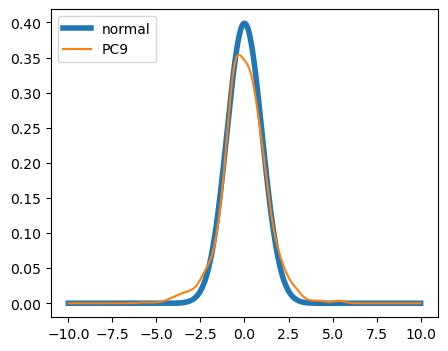

In [25]:
xx = linspace(-10,10,500)
kde_PC9 = stats.gaussian_kde( zdLFC.PC9 )
figure( figsize(5,4) )
plot( xx, stats.norm.pdf( xx), label='normal', linewidth=4 )
plot( xx, kde_PC9.evaluate(xx), label='PC9')

legend(loc=2)
#savefig('normfit-of-zdLFC.pdf')
show()



In [27]:
def reindex_alphbetically(df):
    result = []
    for index, row in df.iterrows():
        a, b = index.split('_')
        if a < b:
            result.append(f'{a}_{b}')
        else:
            result.append(f'{b}_{a}')
    
    
    return(result)


zdLFC.index = reindex_alphbetically(zdLFC)
print(zdLFC)
zdLFC.to_csv("zdLFC Output/Parrish_PC9.csv", index=True)  # Set index=False to exclude the index column

                      PC9
AADAC_AADACL2   -0.815721
AADACL3_AADACL4 -0.662263
ABCC1_ABCC3     -0.008251
ABCC8_ABCC9     -0.395414
ABCD1_ABCD2      0.663730
...                   ...
ZNF503_ZNF703   -0.711393
ZNF143_ZNF76    -2.449984
ZNF419_ZNF773    1.714544
ZNF175_ZNF81    -0.517313
ZYG11A_ZYG11B    0.935192

[1030 rows x 1 columns]
